# Convolutional Neural Network: Live Gesture Recognition

## Data Processing

Begins with checking if my GPU is properly connected to tensorflow, as this will greatly impact the development time of the model.

In [7]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import time
from tensorflow.keras import datasets, layers, models, optimizers



print(device_lib.list_local_devices() )
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Current device: {}".format(tf.test.gpu_device_name()))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10819269952126102446
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10473605848642706997
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4922553139
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8079926747178335883
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 159657761701116562
physical_device_desc: "device: XLA_GPU device"
]
Num GPUs Available:  1
Current device: /device:GPU:0


### Importing Our Image Dataset
This data import assumes that this program and the NUS dataset folder **dataset** lie in the same directory.

1.     The folder 'Hand Postures' contains the 10 class hand posture images (160x120 size). Classes 1 to 10 are named with starting letters 'a' to 'j' respectively.  A total of 2000 hand posture images are present in this folder.

2.     The folder 'Hand Postures with human noise' contains the 10 class hand posture images (320x240 size) with human noises (face of the posturer, human in the background etc). Classes 1 to 10 are named with starting letters 'a_HN' to 'j_HN' respectively.  A total of 750 hand posture images are present in this folder.

3.     The folder 'Backgrounds' contains the background images. A total of 2000 background images are available.

4.     All the images are RGB and in .jpeg format.

In [245]:
import cv2
import numpy as np
import os 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
plt.style.use('ggplot')

def get_images():
    """
    
    Uses cv2, os and numpy to loop through the folder 
    directories and import all images and their labels into numpy arrays X and Y.
    
    Output
    -----
    X: images
        type numpy.array
    Y: labels
        type numpy.array
        
    """
    
    base = 'dataset'
    if os.path.lexists(os.path.join(os.getcwd(), base)):
        directory = os.listdir(base)

    X = []
    Y =[]
    for item in directory:
        path =  base + '/' + item
        files = os.listdir(path)
        for image in files:
            final_path = path + '/' + image
            try:
                img =cv2.imread(final_path)
                img = cv2.resize(img, (256, 128))
                #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
                
                if item == "Hand Postures with human noise":
                    label = image.split("_")[0]
                else:
                    label = image.split()[0]
                label = label.split('.')[0]
                if label == "f" or label == "i" or label == "j":
                    continue
                else:
                    X.append(img)
                    Y.append(label)
            except:
                continue
   
    X = np.array(X, dtype="uint8")
    X = X.reshape(len(X), 128, 256, 3) # Needed to reshape so CNN knows it's different images
    Y = np.array(Y)
    print("Images loaded: ", len(X))
    print("Labels loaded: ", len(Y))
    
    return X,Y


Convert our labels from categorical to numerical values.

In [246]:
def process_Y(Y):
    class_names = list(np.unique(Y))
    for item in class_names:
        print(item, ": ", len(np.where(Y == item)[0]))
    for i,item in enumerate(Y):
        if item in class_names:
            Y[i] = int(class_names.index(item)) 
    Y =  np.array(Y, dtype="uint8")
    return class_names, Y

**Note**: Processing this try/except process ensures that the dataset is loaded the quickest way. If you have already run this notebook before, this will save you time.

In [247]:
try:
    class_names =anp.load("class_names.npy")
    x_train =np.load("x_train.npy")
    y_train = np.load("y_train.npy")
    x_test = np.load("x_test.npy")
    y_test = np.load("y_test.npy")
    
    print("Successfully loaded in the data WITH train-test split")
    
except:
    print("Failed to load pickled dataset WITH train-test split")
    
    try:
        X = anp.load('images.npy')
        Y = np.load('labels.npy')
        class_names = np.load("class_names.npy")
        print("Loaded X (inputs) and Y (labels)")
        
    except:
        print("Failed to load pickled dataset WITHOUT train-test split")
        X,Y = get_images()
        
        background_images = X[0:2000:8]
        background_labels = Y[0:2000:8]
        for i,item in enumerate(X):
            X[i] = item[:,:,::-1]
        X = X[2000:]   #balance the dataset by removing some background images
        Y = Y[2000:]   #balance the dataset by removing some background images
        Y = np.hstack((background_labels, Y))
        X = np.vstack((background_images, X))
        class_names, Y = process_Y(Y)
        np.save("images.npy",X)
        np.save("labels.npy",Y)
        np.save("class_names.npy", class_names)
        print("Computed New X and Y values")


Failed to load pickled dataset WITH train-test split
Failed to load pickled dataset WITHOUT train-test split
Images loaded:  3925
Labels loaded:  3925
BG :  250
a :  275
b :  275
c :  275
d :  275
e :  275
g :  275
h :  275
Computed New X and Y values


In [248]:
true_class_names = ['nothing', 'fist', 'palm', "two fingers up", "shakabra", "o k", "U", "L",
                   ]
np.save("true_class_names.npy", true_class_names)

In [249]:
def split_the_data(X, Y):   
    
    X = X/255.0  ## normalize X array
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
    np.save("x_train.npy",x_train)
    np.save("y_train.npy",y_train)
    np.save("x_test.npy",x_test)
    np.save("y_test.npy",y_test)
    return x_train, x_test, y_train, y_test

In [250]:
try:
    
    x_train, x_test, y_train, y_test = split_the_data(X, Y)      ## Split the data into a training and testing set
   # print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape)
    del X,Y               # delete X and Y from memory
    
except:
    print("Failed to split the data")

Text(0.5, 1.0, 'o k')

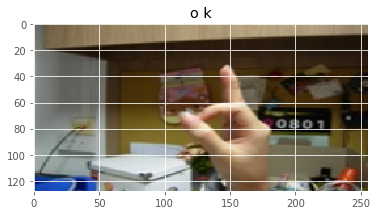

In [251]:
plt.imshow(x_train[200])
plt.title(str(true_class_names[y_train[200]]))

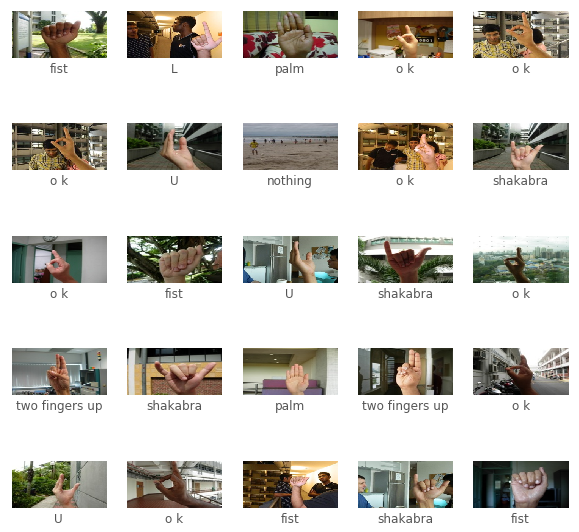

In [252]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(true_class_names[y_train[i]])
plt.show()

In [339]:
def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 256, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3)))
    
    

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(8))
    
    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'] )
    return model

In [340]:
def fit(model, epochs):
    history = model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs=epochs, verbose = 1)
    return history

In [341]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8)

In [342]:
model = build_model()
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_133 (Conv2D)          (None, 126, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_132 (MaxPoolin (None, 63, 127, 64)       0         
_________________________________________________________________
conv2d_134 (Conv2D)          (None, 61, 125, 64)       36928     
_________________________________________________________________
max_pooling2d_133 (MaxPoolin (None, 20, 41, 64)        0         
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 18, 39, 64)        36928     
_________________________________________________________________
max_pooling2d_134 (MaxPoolin (None, 6, 13, 64)         0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 4, 11, 64)       

In [343]:
history = fit(model, 50)

Epoch 1/50
55/55 [==============================] - 4s 64ms/step - loss: 2.0820 - accuracy: 0.1132 - val_loss: 2.0797 - val_accuracy: 0.1195
Epoch 2/50
55/55 [==============================] - 3s 57ms/step - loss: 2.0786 - accuracy: 0.1333 - val_loss: 2.0773 - val_accuracy: 0.1471
Epoch 3/50
55/55 [==============================] - 3s 57ms/step - loss: 2.0700 - accuracy: 0.1506 - val_loss: 2.0579 - val_accuracy: 0.1954
Epoch 4/50
55/55 [==============================] - 3s 57ms/step - loss: 2.0157 - accuracy: 0.1948 - val_loss: 1.9167 - val_accuracy: 0.2253
Epoch 5/50
55/55 [==============================] - 3s 58ms/step - loss: 1.8403 - accuracy: 0.2868 - val_loss: 1.6969 - val_accuracy: 0.3310
Epoch 6/50
55/55 [==============================] - 3s 59ms/step - loss: 1.4755 - accuracy: 0.4333 - val_loss: 1.3667 - val_accuracy: 0.4483
Epoch 7/50
55/55 [==============================] - 3s 59ms/step - loss: 1.1920 - accuracy: 0.5753 - val_loss: 1.0842 - val_accuracy: 0.6161
Epoch 8/50
55

14/14 - 0s - loss: 0.6763 - accuracy: 0.8805


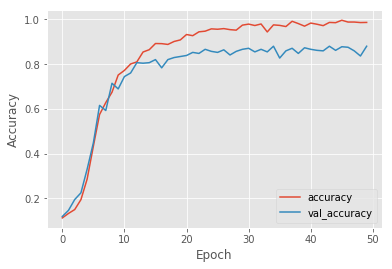

In [344]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig("Accuracy.png")
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

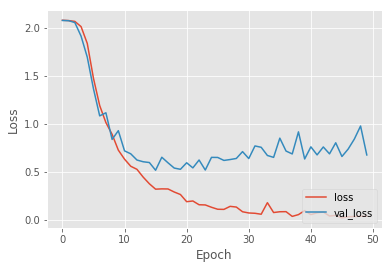

In [345]:
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.savefig("Loss.png")

In [346]:
model.save('saved_model/my_model') 

INFO:tensorflow:Assets written to: saved_model/my_model\assets


## Model Validation

Now that we've trained and saved our best model, let's look at a **Confusion Matrix** for our model's predictions

In [261]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import time
from tensorflow.keras import datasets, layers, models, optimizers
import numpy as np

In [262]:
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")
true_class_names = np.load("true_class_names.npy")
class_names = np.load("class_names.npy")

In [263]:
model = tf.keras.models.load_model('saved_model/my_model')

In [347]:
start_time = time.time()
model.predict(x_test[0].reshape((1,128,256,3)))
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.08001351356506348 seconds ---


In [348]:
predictions = model.predict(x_test)

In [349]:
y_pred = np.argmax(predictions, axis = 1)

conf_columns = []
for item in true_class_names:
    conf_columns.append("Predicted " + item)

conf_indicies = []
for item in true_class_names:
    conf_indicies.append("Actual " + item)
    
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                       columns = conf_columns,
                       index = conf_indicies)

In [350]:
conf_mat

,Predicted nothing,Predicted fist,Predicted palm,Predicted two fingers up,Predicted shakabra,Predicted o k,Predicted U,Predicted L
Actual nothing,46,2,0,0,1,0,0,0
Actual fist,1,60,1,0,1,0,0,0
Actual palm,0,0,52,3,1,1,0,1
Actual two fingers up,1,1,3,45,1,0,0,1
Actual shakabra,0,5,0,0,46,1,1,3
Actual o k,0,0,3,3,0,43,0,2
Actual U,2,0,0,1,2,3,44,1
Actual L,1,2,1,1,0,0,1,47


In [351]:
def guess(model, index, x_test = x_test):
    output = model.predict(x_test[index].reshape((1,128,256,3)))
    plot_prediction(index = index, output = output)
    return output

In [352]:
def plot_prediction(index, output, true_class_names = true_class_names, class_names = class_names):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize = (15,10))
 
    plt.figure(figsize=(12,30))
    clrs = ['blue' if (x == class_names[y_test[index]]) else 'grey' for x in class_names]
    ax1.bar(true_class_names, output[0], color = clrs)
    ax1.set_ylim([0, max(output[0])])
    ax1.set_title("Predicted value: {}".format(true_class_names[np.argmax(output[0])]))
    ax2.imshow(x_test[index])
    ax2.set_title("True value: {}".format(true_class_names[y_test[index]]))
    #plt.ylim(0, output[0].max())
    plt.show()

In [353]:
len(x_test)

435

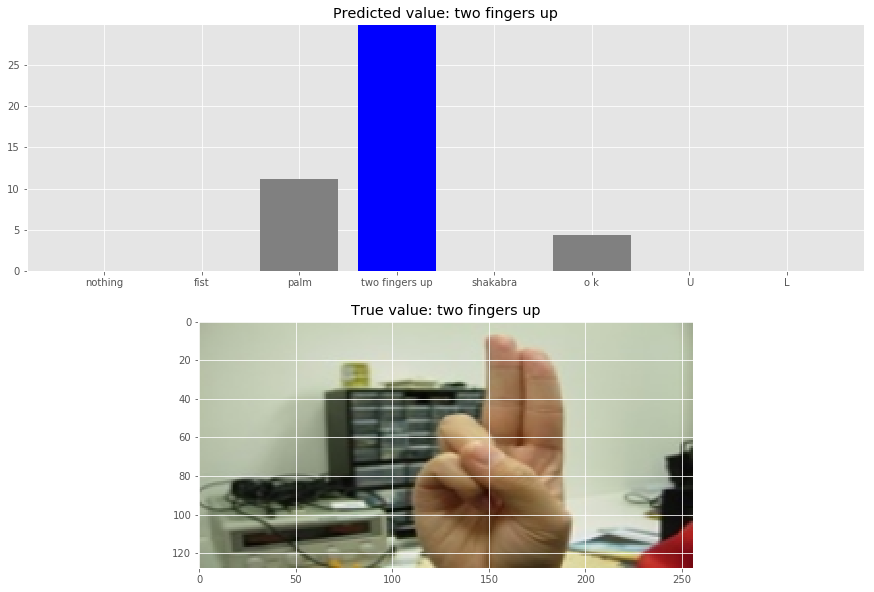

<Figure size 864x2160 with 0 Axes>

[[-25.48504  -19.22747   11.174754  29.878054 -35.92071    4.428974
  -20.812212  -7.447539]]
Gesture:  fist
--- 0.35457587242126465 seconds ---


In [354]:
start_time = time.time()
print(guess(model,22))
print("Gesture: ", true_class_names[np.argmax(model.predict(x_test[0].reshape((1,128,256,3))))])
print("--- %s seconds ---" % (time.time() - start_time))

In [355]:
len(x_test)

435

In [356]:
output = model.predict(x_test[0].reshape((1,128,256,3)))

In [357]:
output

array([[-16.564672 ,  27.713753 ,   7.8097   ,   5.674311 ,  -4.2669144,
         -9.849266 ,  -7.9731164,  -7.7152176]], dtype=float32)

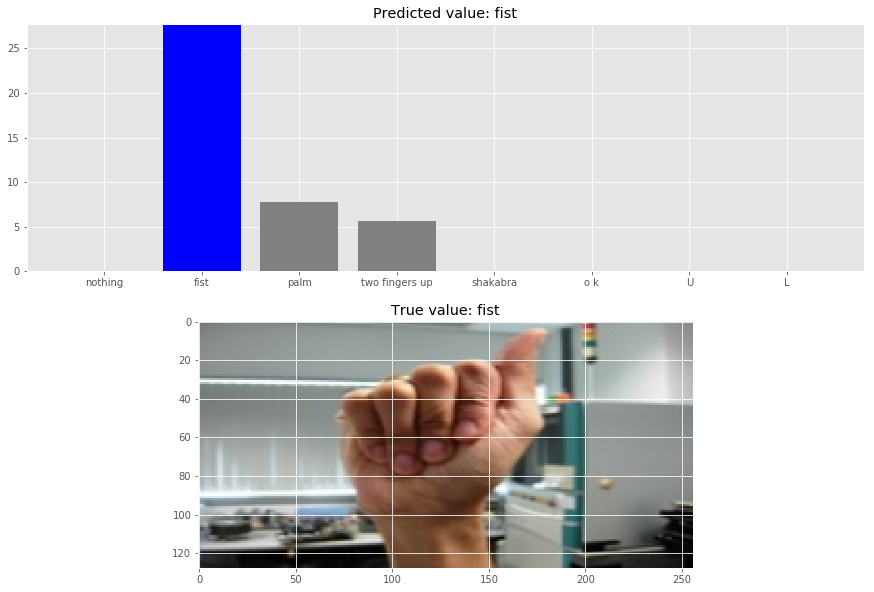

<Figure size 864x2160 with 0 Axes>

array([[-16.564672 ,  27.713753 ,   7.8097   ,   5.674311 ,  -4.2669144,
         -9.849266 ,  -7.9731164,  -7.7152176]], dtype=float32)

In [358]:
guess(model, 0)

Run Time:  0.03191494941711426 seconds

## Testing with Video Input Stream
##### Note: Below are the changes needed in implementation for this to properly work. It is currently under production

Take the average vector output over multiple frames in order to get highest probability gesture!!!

if 60fps... 3 frames /60 frames = 50 / 1000 miliseconds = 0.05 seconds
1 frame / 60 frames = 16.66/1000 miliseconds = 0.0166 seconds

Use multiple cap.read() calls to get images at each time step to average across

In [359]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import time
from tensorflow.keras import datasets, layers, models, optimizers
import numpy as np
import cv2

In [142]:
print(device_lib.list_local_devices() )
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Current device: {}".format(tf.test.gpu_device_name()))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15668584783871478774
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4049685666807963137
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4922553139
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11136332504171736013
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10525922522297954728
physical_device_desc: "device: XLA_GPU device"
]
Num GPUs Available:  1
Current device: /device:GPU:0


In [143]:
model = tf.keras.models.load_model('saved_model/my_model')
true_class_names = np.load("true_class_names.npy")
class_names = np.load("class_names.npy")

In [ ]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

cap = cv2.VideoCapture(0) 

last_prediction = ""
run = True
start_time = time.time()


while run:
    # update data
    
    
    #_, img = cap.read()
    key = cv2.waitKey(1)
    if key == 32:    ## if you press space and image will be taken and processed
        ret, frame = cap.read()

      #  res = cv2.imread(user_input)
        img = cv2.resize(frame,  (256, 128), interpolation=cv2.INTER_CUBIC)

        model_output = model.predict(img.reshape((1,128,256,3)))
        prediction = true_class_names[np.argmax(model_output)]
        
        print(prediction)
        for i, item in enumerate(true_class_names):
            if model_output[0][i] > 300:
                print("%s: %.2f" % (item, model_output[0][i]))
        print("\n")
        #if prediction != last_prediction:
        #    print(prediction)
        #    last_prediction = prediction
    else:
        ret, frame = cap.read()
   
    cv2.imshow("Live Feed", frame)
    #cv2.imshow()
    
    if key == 27:   ##Using the escape key
        break
cap.release()
cv2.destroyAllWindows()

fist
nothing: 3789.62
fist: 5926.30
shakabra: 3162.03


fist
nothing: 3897.30
fist: 5720.63
shakabra: 3327.58


fist
nothing: 1232.40
fist: 1755.64
shakabra: 1051.97
L: 1336.06


nothing
nothing: 2169.29
fist: 666.39
L: 418.27


nothing
nothing: 2469.75
o k: 1923.12


nothing
nothing: 1729.40
L: 1106.00


shakabra
fist: 839.99
shakabra: 2221.78
L: 1597.43


shakabra
nothing: 333.01
fist: 1552.12
shakabra: 2902.86
L: 1166.17


L
nothing: 1217.90
fist: 388.04
L: 1947.57


nothing
nothing: 1711.15
o k: 844.94
U: 712.94
L: 389.23


nothing
nothing: 2751.38
U: 1047.00


L
L: 1977.87


nothing
nothing: 3519.81


nothing
nothing: 2476.06
fist: 580.43
shakabra: 446.44
L: 1652.09


two fingers up
two fingers up: 1157.61
U: 602.74
L: 1135.36


L
nothing: 1015.05
L: 3491.89


L
nothing: 345.21
o k: 1002.92
L: 2259.74


L
o k: 1231.83
L: 2467.52


L
o k: 952.19
L: 2643.95


fist
nothing: 805.65
fist: 2975.57
L: 2455.62


L
nothing: 522.43
o k: 627.06
L: 2673.86


fist
nothing: 967.27
fist: 3345.01

In [ ]:
true_class_names

In [ ]:
model_output